In [1]:
# Import libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
sns.set_theme(style="dark");

In [4]:
# Load data
posts = pd.read_csv('../data/reddit_Cerave_posts_20241109_193458.csv')
comments = pd.read_csv('../data/reddit_Cerave_comments_20241109_193458.csv')

VADER (Valence Aware Dictionary and sEntiment Reasoner) is effective for analyzing sentiments expressed in social media and short text. It provides a compound score that reflects the overall sentiment.

In [21]:
def calculate_sentiment(df, text_columns):
    sia = SentimentIntensityAnalyzer()
    results = {}
    
    for column in text_columns:
        sentiments = df[column].apply(lambda x: sia.polarity_scores(str(x)))
        sentiment_df = pd.DataFrame(sentiments.tolist())
        
        # Add categories
        sentiment_df['category'] = sentiment_df['compound'].apply(
            lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
        )
    
        prefix = column.replace(' ', '_').lower()
        
        df[f'sentiment_{prefix}_compound'] = sentiment_df['compound']
        df[f'sentiment_{prefix}_pos'] = sentiment_df['pos']
        df[f'sentiment_{prefix}_neg'] = sentiment_df['neg']
        df[f'sentiment_{prefix}_neu'] = sentiment_df['neu']
        df[f'sentiment_{prefix}_category'] = sentiment_df['category']
        
        # Calculate statistics
        stats = {
            'Avg Compound Score': sentiment_df['compound'].mean(),
            'Median Compound Score': sentiment_df['compound'].median(),
            'Std Compound Score': sentiment_df['compound'].std(),
            'Positive Texts %': (sentiment_df['category'] == 'positive').mean() * 100,
            'Negative Texts %': (sentiment_df['category'] == 'negative').mean() * 100,
            'Neutral Texts %': (sentiment_df['category'] == 'neutral').mean() * 100,
            'Sample Size': len(df)
        }
        
        results[column] = {
            'sentiments': sentiment_df,
            'stats': stats
        }
        
    return df, results

In [29]:
posts_columns = ['title', 'selftext']
posts_with_sentiment, analysis_results = calculate_sentiment(posts, posts_columns)

for column in posts_columns:
    print(f"\nAnalysis for {column}:")
    for key, value in analysis_results[column]['stats'].items():
        print(f"{key}: {value:.2f}")


Analysis for title:
Avg Compound Score: 0.16
Median Compound Score: 0.00
Std Compound Score: 0.34
Positive Texts %: 46.73
Negative Texts %: 13.56
Neutral Texts %: 39.71
Sample Size: 413.00

Analysis for selftext:
Avg Compound Score: 0.53
Median Compound Score: 0.80
Std Compound Score: 0.57
Positive Texts %: 80.63
Negative Texts %: 16.22
Neutral Texts %: 3.15
Sample Size: 413.00


In [28]:
comments_columns = ['body']
comments_with_sentiment, analysis_results = calculate_sentiment(comments, comments_columns)

for column in comments_columns:
    print(f"\nAnalysis for {column}:")
    for key, value in analysis_results[column]['stats'].items():
        print(f"{key}: {value:.2f}")



Analysis for body:
Avg Compound Score: 0.38
Median Compound Score: 0.58
Std Compound Score: 0.57
Positive Texts %: 69.38
Negative Texts %: 23.44
Neutral Texts %: 7.18
Sample Size: 209.00


In [30]:
def plot_sentiment(df, column):
    prefix = column.replace(' ', '_').lower()
    compound_col = f'sentiment_{prefix}_compound'
    category_col = f'sentiment_{prefix}_category'
    
    plt.figure(figsize=(12, 4))
    
    # Sentiment Distribution
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=compound_col, bins=30)
    plt.title(f'Sentiment Distribution - {column}')
    plt.xlabel('Compound Score')
    
    # Category Distribution
    plt.subplot(1, 2, 2)
    category_counts = df[category_col].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, hue=category_counts.values, palette='Paired')
    plt.title(f'Sentiment Categories - {column}')
    plt.ylabel('Count')
    
    plt.tight_layout()

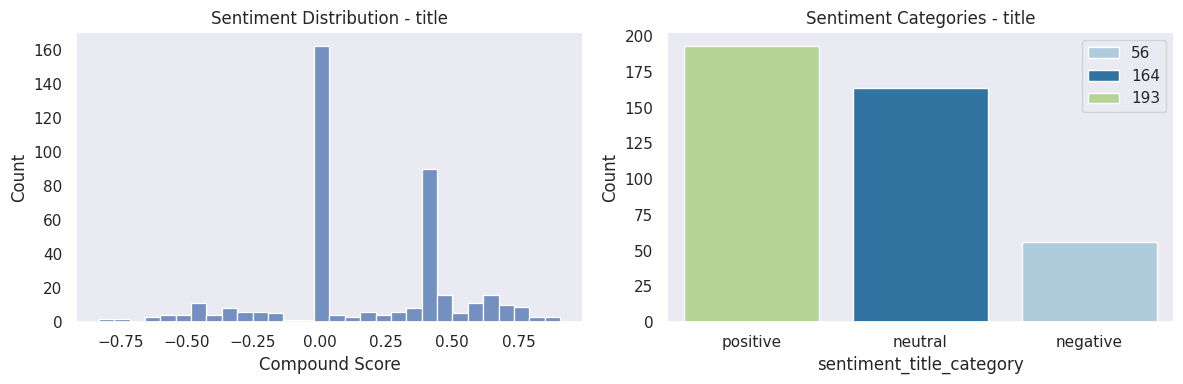

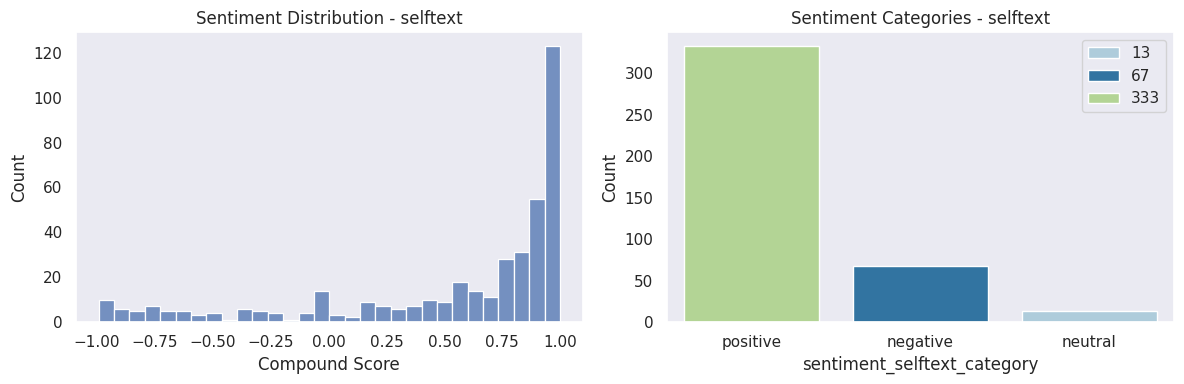

In [31]:
for column in posts_columns:
    plot_sentiment(posts_with_sentiment, column)

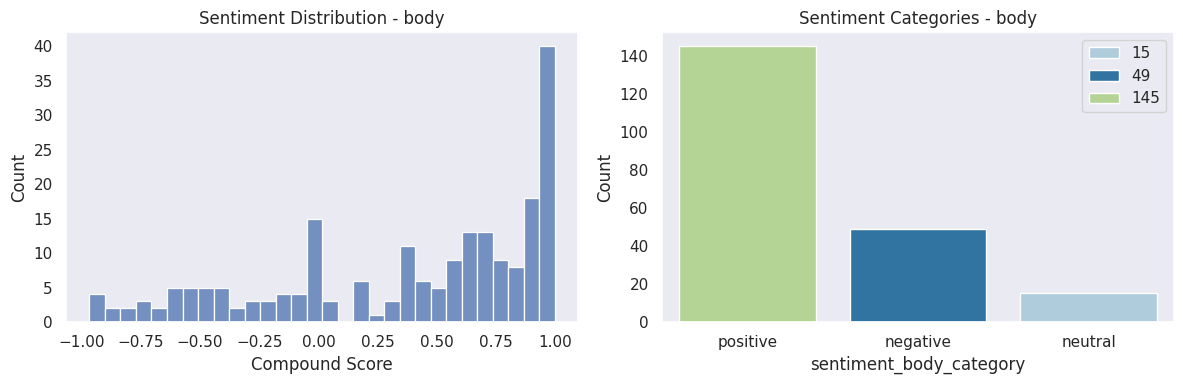

In [32]:
for column in comments_columns:
    plot_sentiment(comments_with_sentiment, column)

In [34]:
def display_most_negative(df, column, n=10):
    prefix = column.replace(' ', '_').lower()
    compound_col = f'sentiment_{prefix}_compound'
    
    # Get most negative comments
    most_negative = df.nsmallest(n, compound_col)[[column, compound_col]]
    
    print(f"\n{n} Most Negative {column}s:")
    print("="*50)
    for idx, row in most_negative.iterrows():
        print(f"\nScore: {row[compound_col]:.3f}")
        print(f"Text: {row[column]}")
        print("-"*50)

display_most_negative(comments_with_sentiment, 'body', 10)


10 Most Negative bodys:

Score: -0.967
Text: Did you cut out water, too? It s processed not to contain bacteria that are detrimental to humans. Tallow comes with risks, and I m sick of people pretending every chemical is dangerous. It stinks like hell all the tallow I ve smelled unless it s packed with perfume. When tallow apparently works for someone, all I hear is I didn t moisturize properly , so my oil glands were overproducing to make up for it, which led to my acne. You only tried Cerave and every moisturizer but tallow is bad? You were getting 20 new cysts weekly your face would be covered and didn t see a derm? I call this post Cerave shitting and fake.
--------------------------------------------------

Score: -0.961
Text: Hi, I got a similar case to yours a few years ago, after I wasted around 150 dollars, there are some details you can see to determine if it s fake or not, so I ll break this down based on what I know, Packaging the real packaging have a more matte feel than

In [36]:
display_most_negative(posts_with_sentiment, 'selftext', 10)


10 Most Negative selftexts:

Score: -0.991
Text: I m 24 and never really had a problem with acne until recently except for some spots around my period. I really need help understanding what s going on and what I can do to help please! I have had the most horrible and stressful summer and since around end of August after my period I started to notice the sports that appeared during my period didn t heal and I had a lot of texture and skin coloured bumps. I thought it was stress related and would go away on their on but it has progressively gotten worse. I have red and colorless bumps, some with gunk in but not all. My cheeks are red and sting a lot. I always had dry skin but feels hot and tighter than usual. I hate seeing my face but I am also so uncomfortable with my face getting inflamed all the time. I had switched to new skincare routine due to skin still feeling dry and I thought I could upgrade as I could afford more things now It also took me two months to swtich products as I d

In [35]:
display_most_negative(posts_with_sentiment, 'title', 10)


10 Most Negative titles:

Score: -0.832
Text: Breaking out terribly. Bad products, acne or damaged skin barrier? Routine Help
--------------------------------------------------

Score: -0.791
Text: Routine advice for someone with chronic pain depression
--------------------------------------------------

Score: -0.771
Text: My skin is the worst it s ever been - I m desperate!
--------------------------------------------------

Score: -0.718
Text: Help! My skin is an unmitigated disaster and I m despairing
--------------------------------------------------

Score: -0.631
Text: Acne is gone, but skin is worse in every other way after taking Accutane.
--------------------------------------------------

Score: -0.625
Text: Acne Am I destroying my skin barrier?
--------------------------------------------------

Score: -0.624
Text: Trains and Office Ruin My Skin!
--------------------------------------------------

Score: -0.583
Text: Is the Cerave SA cleanser really that bad for a daily cl